# SECOM Yield Prediction — End-to-End Notebook

**Goal:** Predict *Fail* outcomes from process measurements to reduce scrap and downtime.

**Data:** `data/secom.data`, `data/secom_labels.data`, `data/secom.names` (UCI ML Repository, real fab data).

**Primary metric:** Recall on *Fail* at acceptable precision. Report PR-AUC and Balanced Error Rate (BER).

### 1. Setup

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib


# Global style for plots
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False,
    "figure.dpi": 150,
    "legend.frameon": True,
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
    "legend.fontsize": 12
})

# Apply to seaborn
sns.set_theme(context="notebook", style="ticks")

# Reproducibility
rnd_num = 42
rng = np.random.seed(rnd_num)

# Root directory
ROOT = Path(os.getcwd()).parent

# Data directory
DATA_DIR = Path(ROOT/"data")
RAW = Path(DATA_DIR/"raw")
assert (RAW/"secom.data").exists() and (RAW/"secom_labels.data").exists(), "Data files are missing!"

# Results directory
RESULT_DIR = Path(ROOT/"results")
RESULT_DIR.mkdir(exist_ok=True, parents=True)

# Model directory
MODEL_DIR = Path(ROOT/"models")
MODEL_DIR.mkdir(exist_ok=True, parents=True)

In [2]:
# Figure saver helper (use after each plot)
RESULT_DIR_IR = Path(RESULT_DIR/"interpretability")
RESULT_DIR_IR.mkdir(exist_ok=True, parents=True)
def savefig(name):
    out = RESULT_DIR_IR/name
    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")
    print("Saved:", out)

### 2. Libraries

In [3]:
# Libraries
import torch
import shap
from sklearn.metrics import (precision_recall_curve, average_precision_score,
                             roc_auc_score, balanced_accuracy_score,
                             confusion_matrix, classification_report,
                             brier_score_loss, roc_curve)

### 3. Reload data from `03_Modeling.ipynb`.

In [4]:
# Set the paths
PROC = Path(DATA_DIR/"processed")
MODELS = Path(ROOT/"models")

# Reload data
tr = pd.read_parquet(PROC/"train.parquet")
va = pd.read_parquet(PROC/"val.parquet")
te = pd.read_parquet(PROC/"test.parquet")
feat_cols = [c for c in tr.columns if c not in ("label","timestamp")]

Xva, yva = va[feat_cols].to_numpy(dtype=np.float32), va["label"].to_numpy(dtype=np.int8)
Xte, yte = te[feat_cols].to_numpy(dtype=np.float32), te["label"].to_numpy(dtype=np.int8)

# Reload models
lr   = joblib.load(MODELS/"logistic.pkl")
rf   = joblib.load(MODELS/"random_forest.pkl")
xgb  = joblib.load(MODELS/"xgb.pkl")
best_sel_pipe = joblib.load(MODELS/"feature_select_winner.pkl")
meta = joblib.load(MODELS/"stack_meta.pkl")

# Reload MLP (torch)
class MLP(torch.nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(d_in, 256), torch.nn.ReLU(), torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 128), torch.nn.ReLU(), torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 1)
        )
    def forward(self, x): return self.net(x)

mlp_model = MLP(len(feat_cols))
mlp_model.load_state_dict(torch.load(MODELS/"mlp_state.pt", map_location="cpu"))
mlp_model.eval()

/Users/enigma/anaconda3/envs/DS/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:56:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1717011574866/work/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_66042/2090203102.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://

MLP(
  (net): Sequential(
    (0): Linear(in_features=375, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

### 4. Evaluation curves: PR & ROC for all saved models

In [5]:
def proba_sklearn(model, X):
    # works for LR, RF, XGB, pipelines, meta
    return model.predict_proba(X)[:, 1].astype("float64")

def proba_mlp(mlp, X):
    device = next(mlp.parameters()).device if list(mlp.parameters()) else torch.device("cpu")
    with torch.no_grad():
        Xt = torch.tensor(X, dtype=torch.float32, device=device)
        p  = torch.sigmoid(mlp(Xt)).cpu().numpy().ravel()
    return p.astype("float64")

In [6]:
# Collect model probabilities on TEST
curves = {}

try:    curves["Logistic"] = proba_sklearn(lr, Xte)
except: pass
try:    curves["RandomForest"] = proba_sklearn(rf, Xte)
except: pass
try:    curves["XGBoost"] = proba_sklearn(xgb, Xte)
except: pass
try:    curves["FeatureSel (best pipe)"] = proba_sklearn(best_sel_pipe, Xte)
except: pass
try:    curves["MLP"] = proba_mlp(mlp_model, Xte)
except: pass

In [7]:
# Optionally include stacking/meta if base probas are available:
try:
    # rebuild meta inputs using the same base models as training time
    lr_p  = proba_sklearn(lr, Xte)
    rf_p  = proba_sklearn(rf, Xte)
    mlp_p = proba_mlp(mlp_model, Xte)
    Xte_stack = np.vstack([lr_p, rf_p, mlp_p]).T
    curves["Stacking (meta)"] = proba_sklearn(meta, Xte_stack)
except Exception:
    pass

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/01_pr_curve_test.png


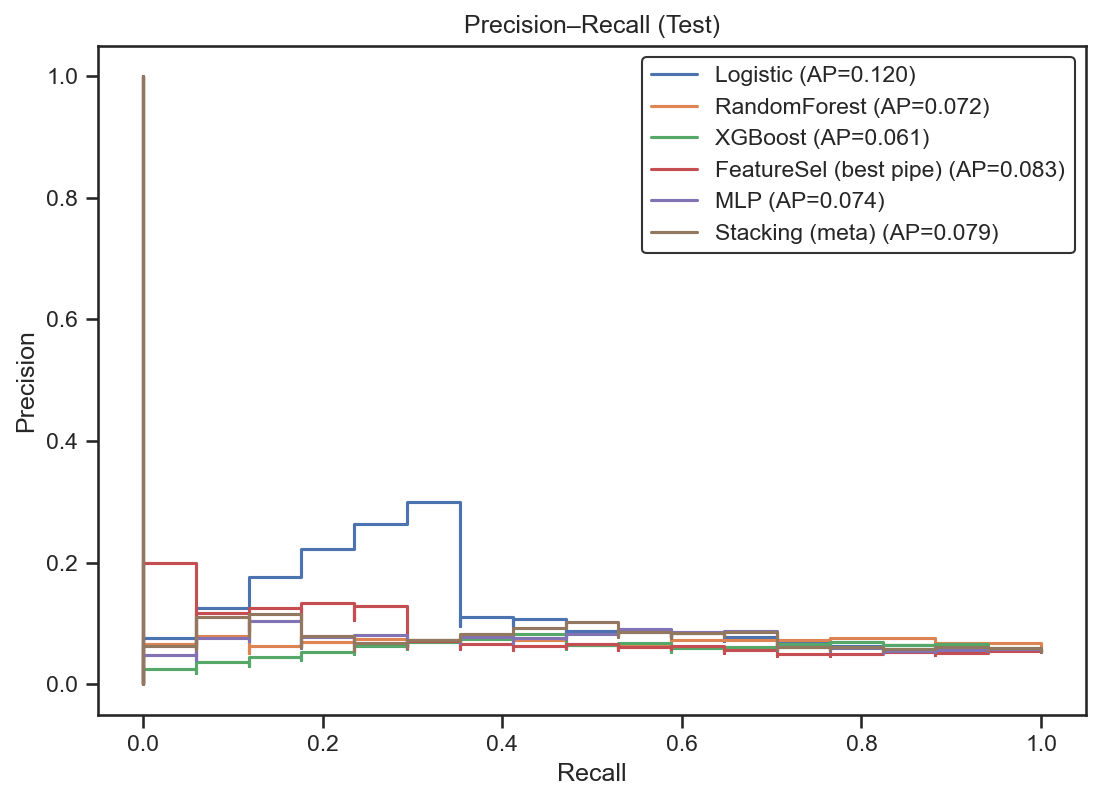

In [8]:
# ---- Plot Precision–Recall
plt.figure(figsize=(7.5, 5.5))
for name, p in curves.items():
    prec, rec, _ = precision_recall_curve(yte, p)
    ap = average_precision_score(yte, p)
    plt.step(rec, prec, where="post", label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (Test)")
plt.legend(frameon=True)
plt.tight_layout()
savefig("01_pr_curve_test.png")
plt.show()

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/02_roc_curve_test.png


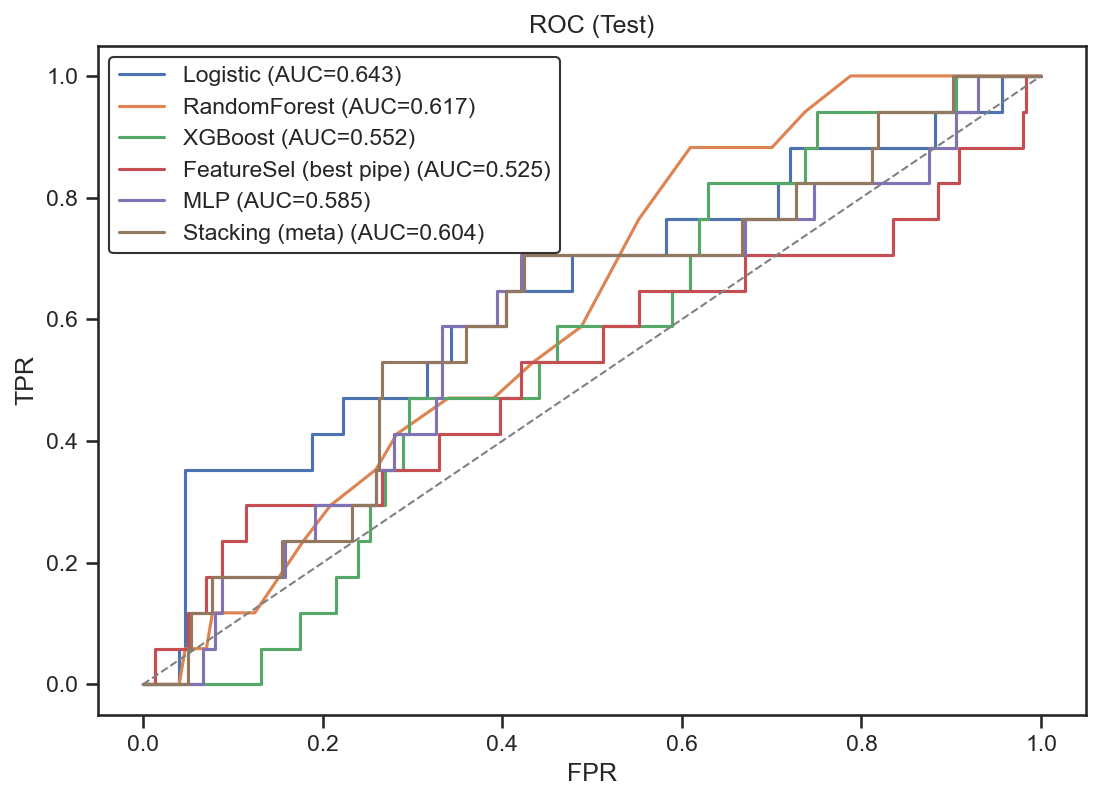

In [9]:
# ---- Plot ROC
plt.figure(figsize=(7.5, 5.5))
for name, p in curves.items():
    fpr, tpr, _ = roc_curve(yte, p)
    auc = roc_auc_score(yte, p)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],"--", lw=1, color="gray")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Test)")
plt.legend(frameon=True)
plt.tight_layout()
savefig("02_roc_curve_test.png")
plt.show()

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/03_pr_recall_vs_threshold_logistic.png


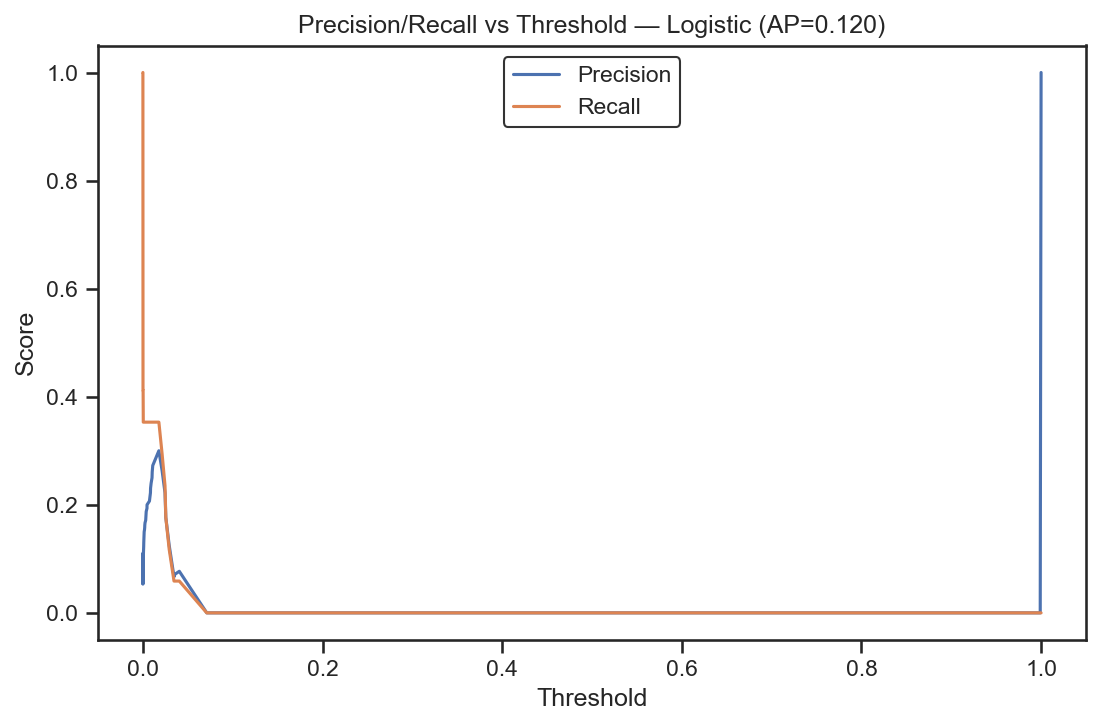

Included models: ['Logistic', 'RandomForest', 'XGBoost', 'FeatureSel (best pipe)', 'MLP', 'Stacking (meta)']


In [10]:
# ---- Threshold -> Precision/Recall for the best PR-AUC model
aps = {name: average_precision_score(yte, p) for name, p in curves.items()}
best_name = max(aps, key=aps.get)
best_p = curves[best_name]
prec, rec, thr = precision_recall_curve(yte, best_p)
thr_full = np.r_[thr, 1.0]

fig, ax = plt.subplots(figsize=(7.5, 5.0))
ax.plot(thr_full, prec, label="Precision")
ax.plot(thr_full, rec, label="Recall")
ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.set_title(f"Precision/Recall vs Threshold — {best_name} (AP={aps[best_name]:.3f})")
ax.legend(frameon=True)
plt.tight_layout()
savefig(f"03_pr_recall_vs_threshold_{best_name.lower().replace(' ','_')}.png")
plt.show()

print("Included models:", list(curves.keys()))

#### 3. SHAP (SHapley Additive exPlanations) Interpretability

In [11]:
# Helper Functions
def pr_align(y, p):
    P, R, T = precision_recall_curve(y, p); return P[:-1], R[:-1], T
def thr_f1(y, p, beta=1.0):
    P, R, T = pr_align(y, p); F = (1+beta**2)*(P*R)/(beta**2*P+R+1e-12)
    i = np.nanargmax(F); return float(T[i])
def thr_recall(y, p, floor=0.10):
    P, R, T = pr_align(y, p); idx = np.where(R>=floor)[0]
    return float(T[idx[np.argmax(P[idx])]]) if idx.size else float(T[-1])
def eval_at(name, y, p, thr):
    pred = (p>=thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    return dict(Model=name, thr=float(thr),
                PR_AUC=average_precision_score(y, p),
                ROC_AUC=roc_auc_score(y, p),
                BalancedAcc=balanced_accuracy_score(y, pred),
                TP=int(tp), FP=int(fp), TN=int(tn), FN=int(fn))

In [12]:
# Gather candidates robustly (uses whatever exists)
cands = []  # (name, p_val, p_test)
def add_if(name, p_val, p_test):
    if p_val is None or p_test is None: return
    if len(p_val)==len(yva) and len(p_test)==len(yte):
        cands.append((name, np.asarray(p_val), np.asarray(p_test)))

try: add_if("Logistic", lr_proba_val, lr_proba_te)
except NameError: pass
try: add_if("RandomForest", rf_proba_val, rf_proba_te)
except NameError: pass
try: add_if("XGBoost", p_val, p_te)             # from your XGB section
except NameError: pass
try: add_if("MLP", mlp_proba_val, mlp_proba_te)
except NameError: pass
try: add_if("AvgEnsemble", (lr_proba_val+rf_proba_val+mlp_proba_val)/3, (lr_proba_te +rf_proba_te +mlp_proba_te )/3)
except NameError: pass
try: add_if("FeatureSel (best pipe)",
            best["pipe"].predict_proba(Xva)[:,1],
            best["pipe"].predict_proba(Xte)[:,1])
except Exception: pass
try: add_if("Stacking (meta)", stack_val, stack_test)
except NameError: pass

print("Included models:", [n for n,_,_ in cands])

Included models: []


#### 3.2. Cross-model evaluation table

In [13]:
# Collect per-model probabilities on VALIDATION and TEST
val_probs, test_probs = {}, {}

def add_model(name, prob_val_fn, prob_test_fn):
    try:
        pv = prob_val_fn()
        pt = prob_test_fn()
        if (len(pv)==len(yva)) and (len(pt)==len(yte)):
            val_probs[name]  = pv.astype("float64")
            test_probs[name] = pt.astype("float64")
    except Exception as e:
        print(f"[skip] {name}: {e}")

# base models
add_model("Logistic",
          lambda: proba_sklearn(lr, Xva),
          lambda: proba_sklearn(lr, Xte))

add_model("RandomForest",
          lambda: proba_sklearn(rf, Xva),
          lambda: proba_sklearn(rf, Xte))

add_model("XGBoost",
          lambda: proba_sklearn(xgb, Xva),
          lambda: proba_sklearn(xgb, Xte))

add_model("FeatureSel (best pipe)",
          lambda: proba_sklearn(best_sel_pipe, Xva),
          lambda: proba_sklearn(best_sel_pipe, Xte))

add_model("MLP",
          lambda: proba_mlp(mlp_model, Xva),
          lambda: proba_mlp(mlp_model, Xte))

# stacking/meta (rebuild meta inputs exactly like in Section 2)
def stack_val():
    lr_p  = proba_sklearn(lr, Xva)
    rf_p  = proba_sklearn(rf, Xva)
    mlp_p = proba_mlp(mlp_model, Xva)
    return meta.predict_proba(np.vstack([lr_p, rf_p, mlp_p]).T)[:,1]

def stack_test():
    lr_p  = proba_sklearn(lr, Xte)
    rf_p  = proba_sklearn(rf, Xte)
    mlp_p = proba_mlp(mlp_model, Xte)
    return meta.predict_proba(np.vstack([lr_p, rf_p, mlp_p]).T)[:,1]

add_model("Stacking (meta)", stack_val, stack_test)

print("Included models:", list(test_probs.keys()))

# --- helpers (thresholds & metrics) ---

def _align_pr(y, p):
    P, R, T = precision_recall_curve(y, p)
    return P[:-1], R[:-1], T  # align thresholds

def thr_f1(y, p, beta=1.0):
    P, R, T = _align_pr(y, p)
    F = (1+beta**2)*(P*R)/(beta**2*P + R + 1e-12)
    i = int(np.nanargmax(F))
    return float(T[i])

def thr_recall_floor(y, p, floor=0.10):
    P, R, T = _align_pr(y, p)
    ok = np.where(R >= floor)[0]
    if ok.size == 0:  # fallback: F1
        return thr_f1(y, p)
    j = ok[np.argmax(P[ok])]
    return float(T[j])

def eval_at(name, y, p, thr):
    pred = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    return dict(
        Model=name, thr=float(thr),
        PR_AUC=average_precision_score(y, p),
        ROC_AUC=roc_auc_score(y, p),
        BalancedAcc=balanced_accuracy_score(y, pred),
        TP=int(tp), FP=int(fp), TN=int(tn), FN=int(fn)
    )

# --- build table for two policies using VAL to pick thr, TEST to report ---
rows = []
for name in test_probs.keys():
    pv, pt = val_probs[name], test_probs[name]
    t1 = thr_f1(yva, pv)
    t2 = thr_recall_floor(yva, pv, floor=0.10)
    rows.append({**eval_at(name, yte, pt, t1), "Policy":"F1-opt"})
    rows.append({**eval_at(name, yte, pt, t2), "Policy":"Recall≥10%"})

if rows:
    df_eval = (pd.DataFrame(rows)
               .sort_values(["Policy","PR_AUC"], ascending=[True, False])
               .reset_index(drop=True))
    display(df_eval[["Model","Policy","PR_AUC","ROC_AUC","BalancedAcc","thr","TP","FP","TN","FN"]].round(4))
else:
    print("No models produced probabilities — nothing to evaluate.")

Included models: ['Logistic', 'RandomForest', 'XGBoost', 'FeatureSel (best pipe)', 'MLP', 'Stacking (meta)']


,Model,Policy,PR_AUC,ROC_AUC,BalancedAcc,thr,TP,FP,TN,FN
0,Logistic,F1-opt,0.1196,0.6425,0.4966,0.9536,0,2,295,17
1,FeatureSel (best pipe),F1-opt,0.0832,0.5249,0.5343,0.0018,5,67,230,12
2,Stacking (meta),F1-opt,0.0791,0.6039,0.5218,0.5087,2,22,275,15
3,MLP,F1-opt,0.0736,0.5847,0.6105,0.1509,12,144,153,5
4,RandomForest,F1-opt,0.0715,0.6172,0.5653,0.0675,8,101,196,9
5,XGBoost,F1-opt,0.0606,0.5522,0.5483,0.0333,10,146,151,7
6,Logistic,Recall≥10%,0.1196,0.6425,0.5793,0.0000,13,180,117,4
7,FeatureSel (best pipe),Recall≥10%,0.0832,0.5249,0.5343,0.0018,5,67,230,12
8,Stacking (meta),Recall≥10%,0.0791,0.6039,0.5218,0.5087,2,22,275,15
9,MLP,Recall≥10%,0.0736,0.5847,0.6105,0.1509,12,144,153,5


#### 3.3. SHAP Interpretability (RandomForest + XGBoost)

/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_66042/2526240384.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_rf, Xte_sub, feature_names=Xte_sub.columns, plot_type="bar", show=False)


Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/04_shap_rf_summary_bar.png


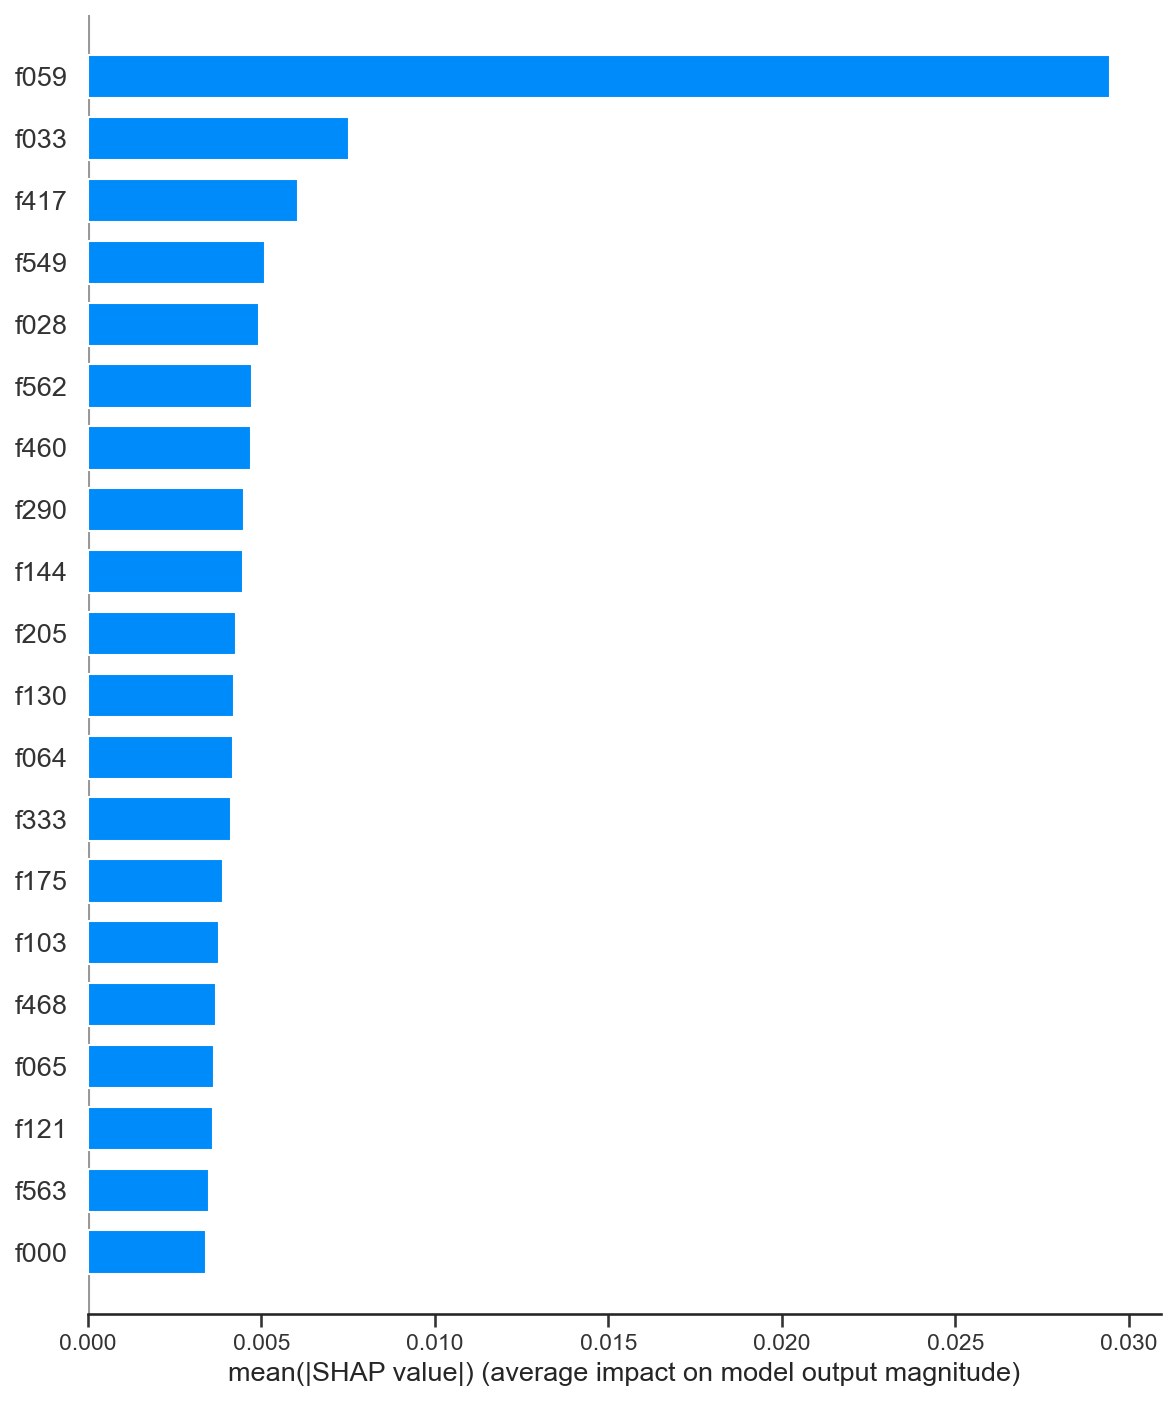

/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_66042/2526240384.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_rf, Xte_sub, feature_names=Xte_sub.columns, show=False)


Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/05_shap_rf_beeswarm.png


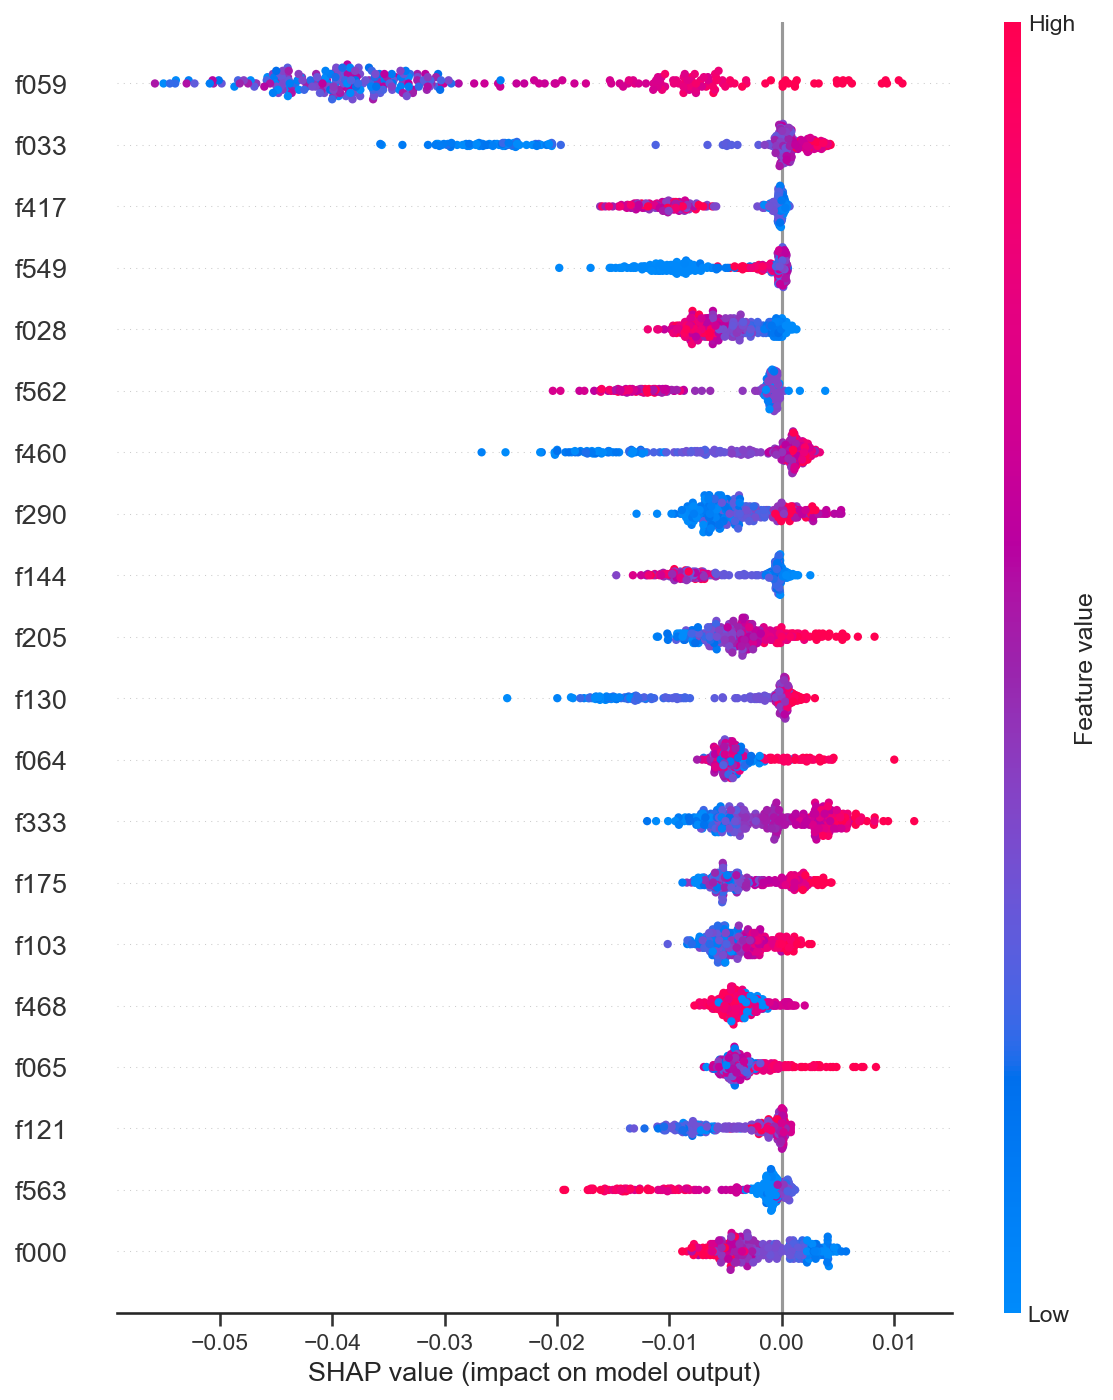

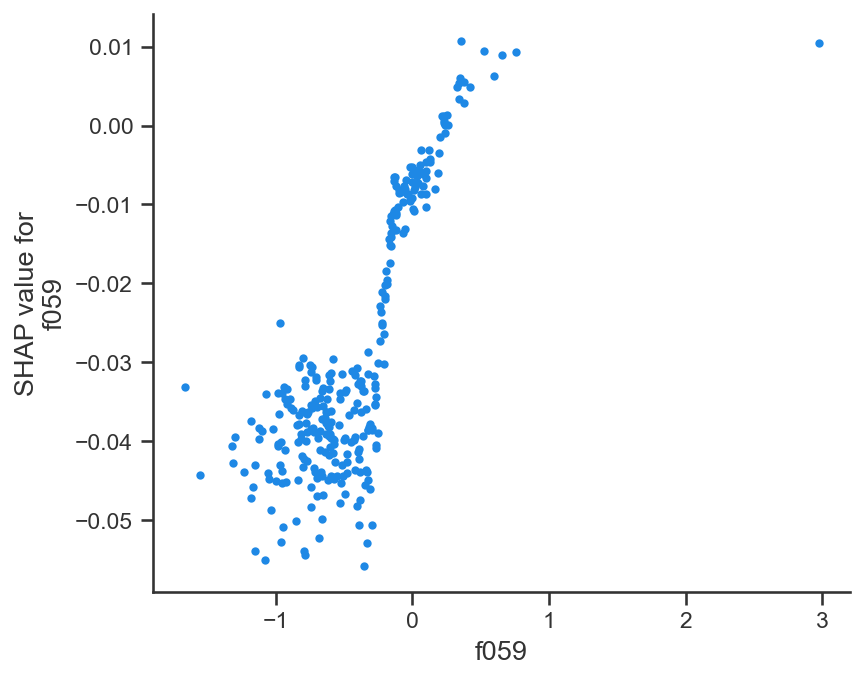

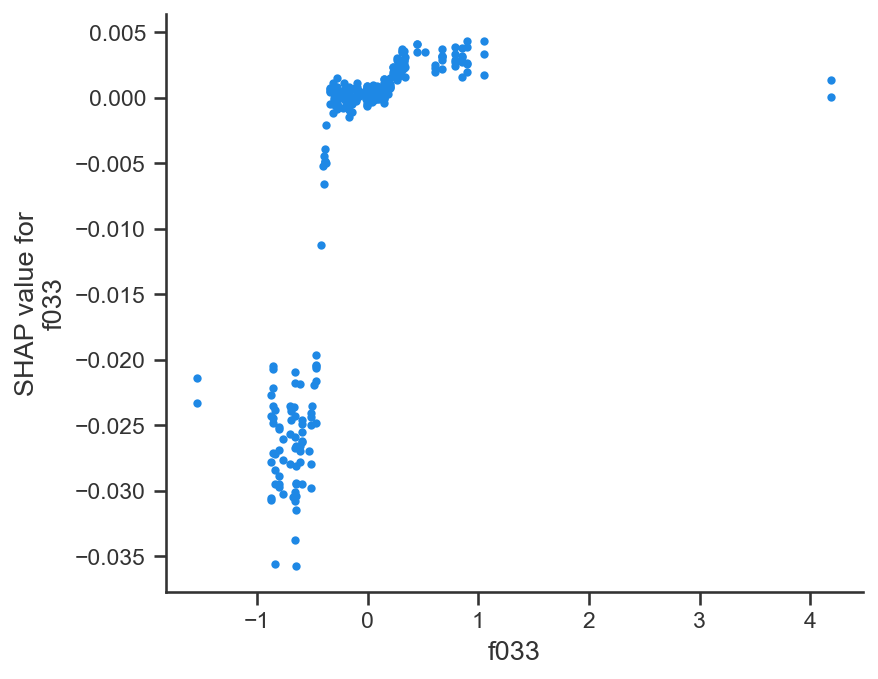

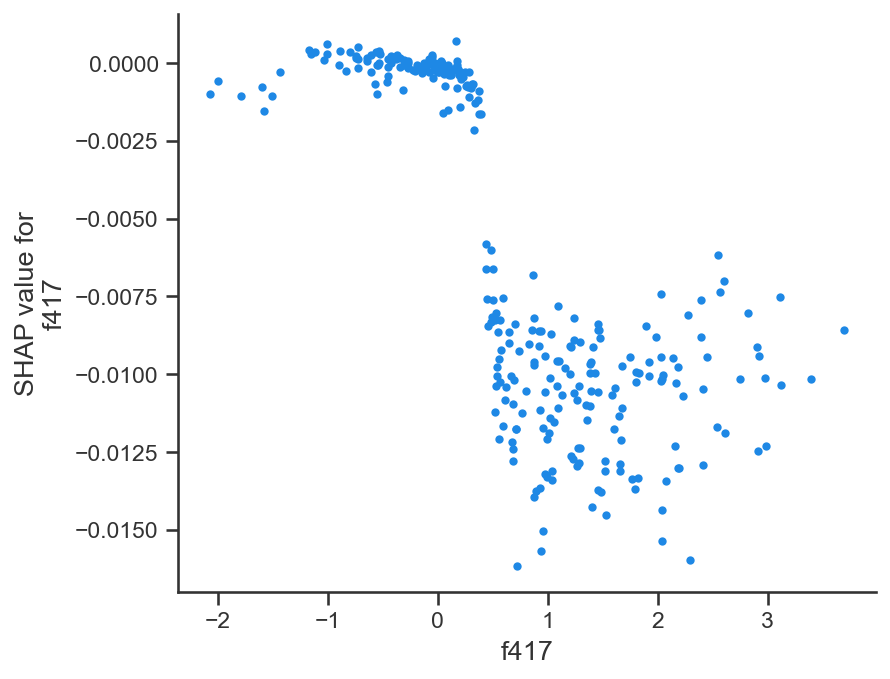

/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_66042/2526240384.py:43: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_xgb, Xte_sub, feature_names=Xte_sub.columns, plot_type="bar", show=False)


Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/06_shap_xgb_summary_bar.png


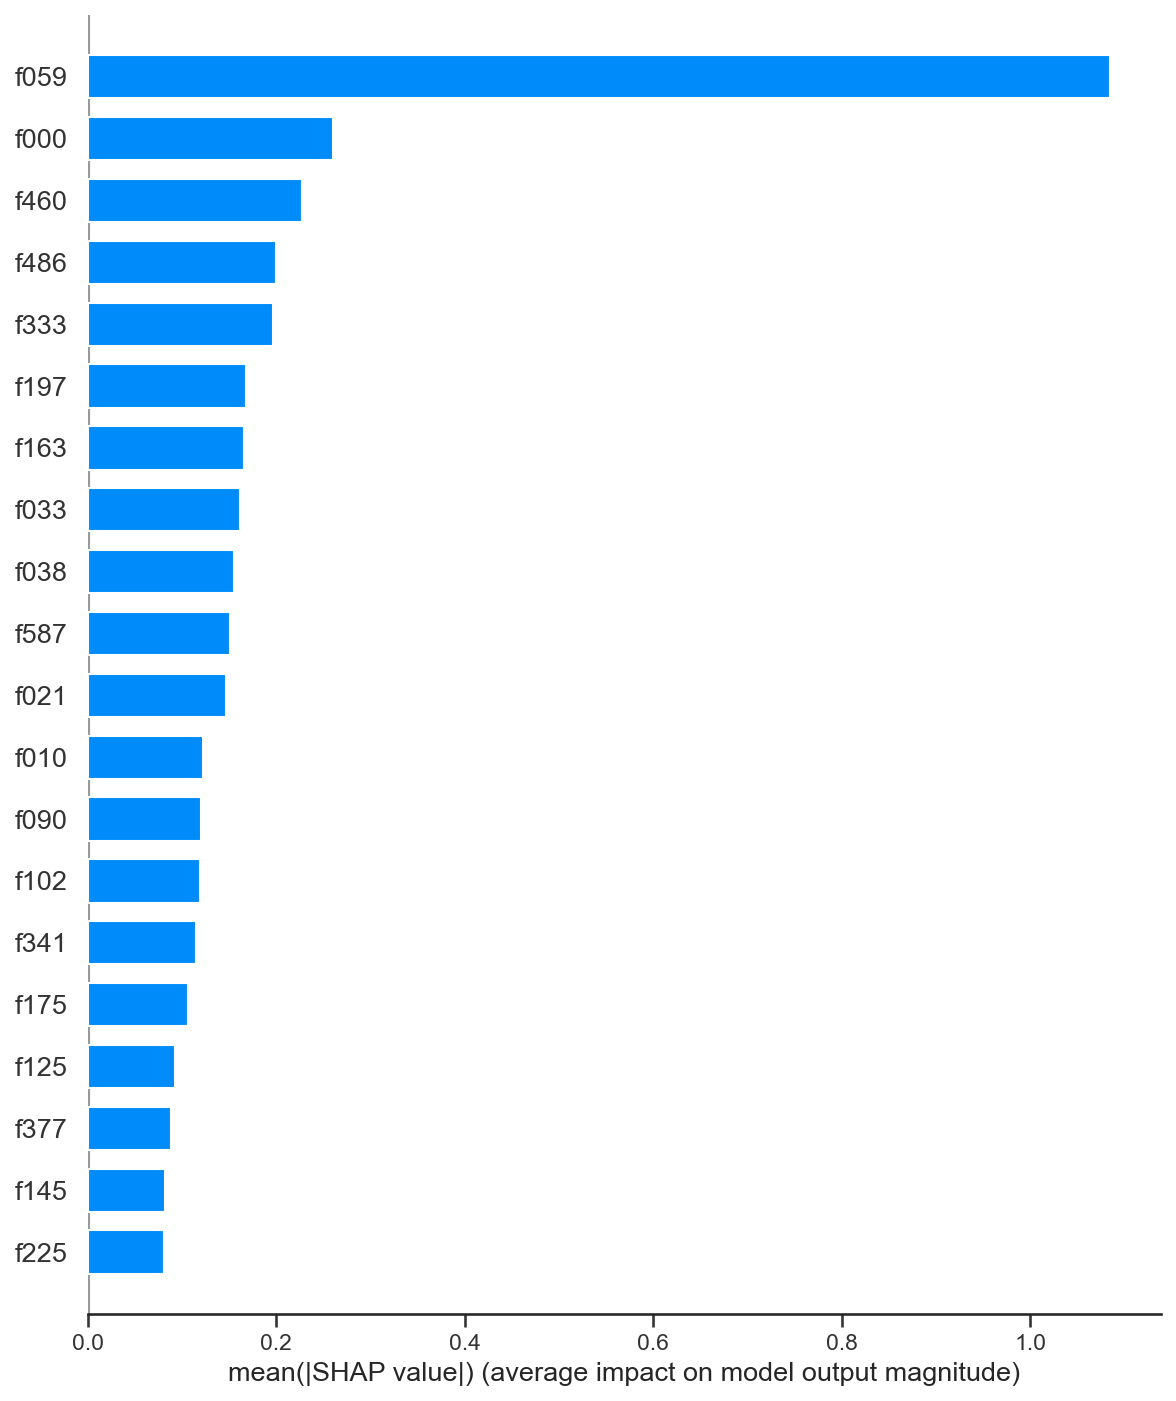

/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_66042/2526240384.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_xgb, Xte_sub, feature_names=Xte_sub.columns, show=False)


Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/07_shap_xgb_beeswarm.png


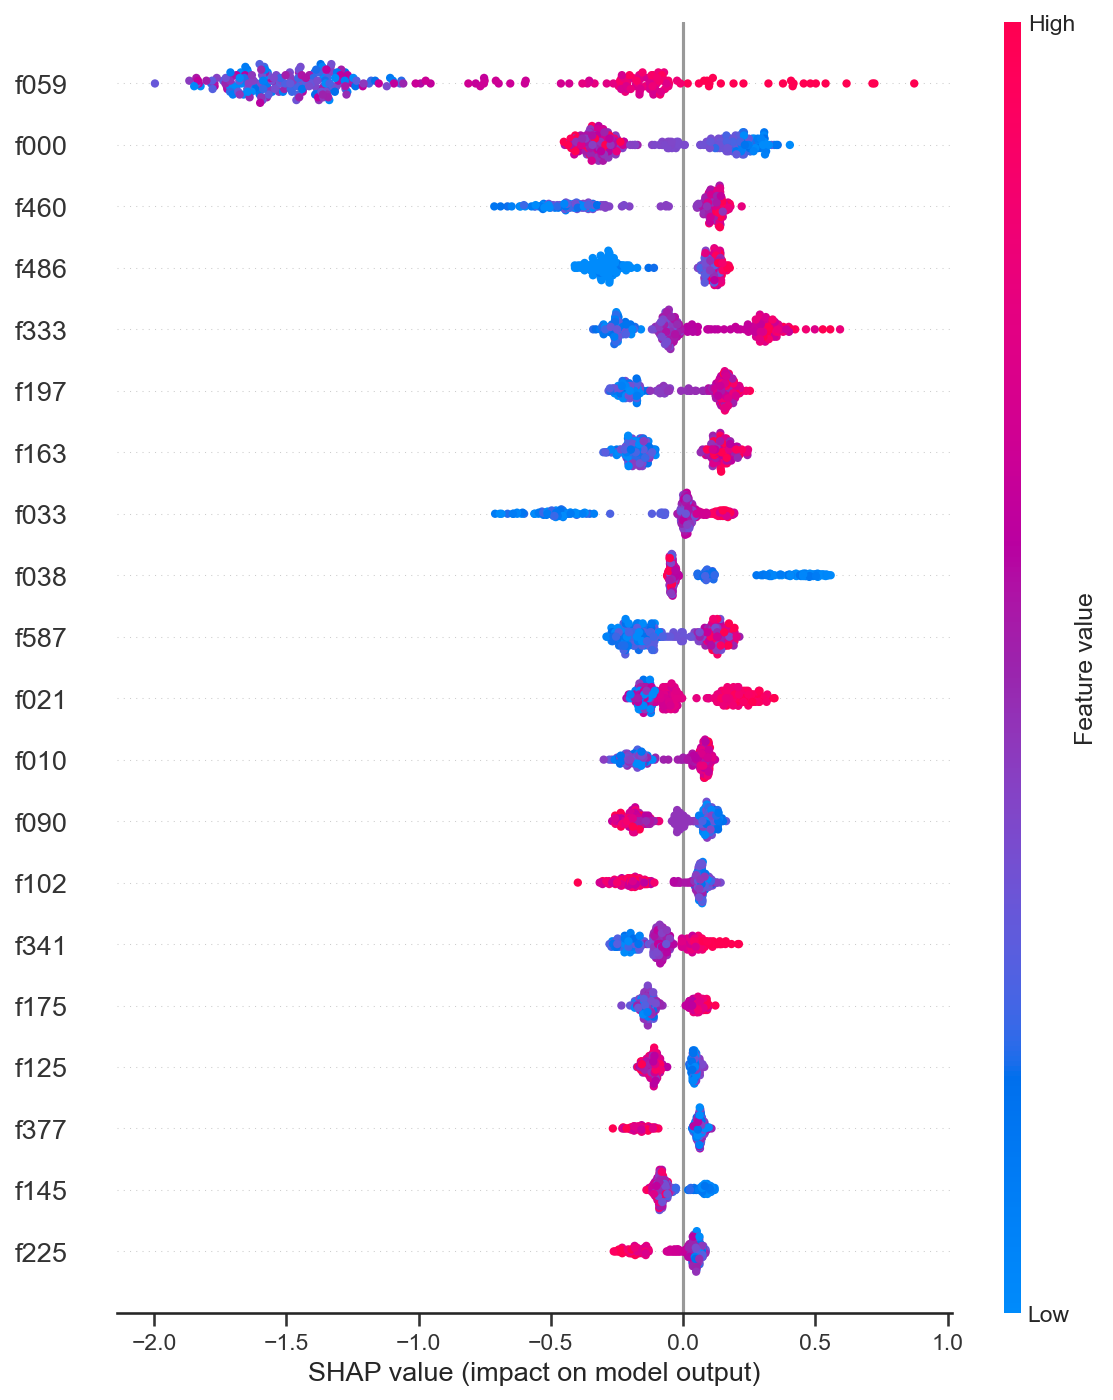

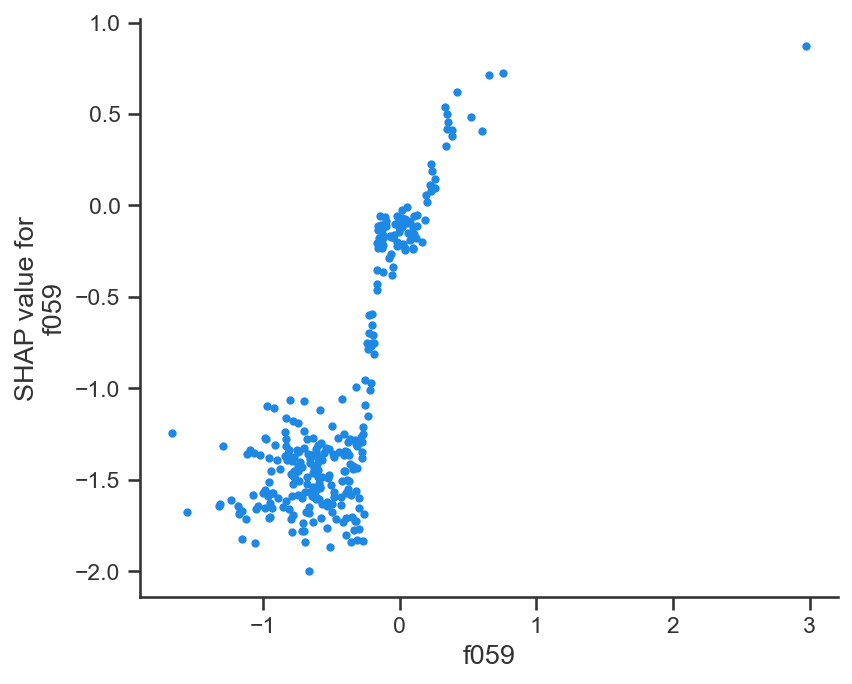

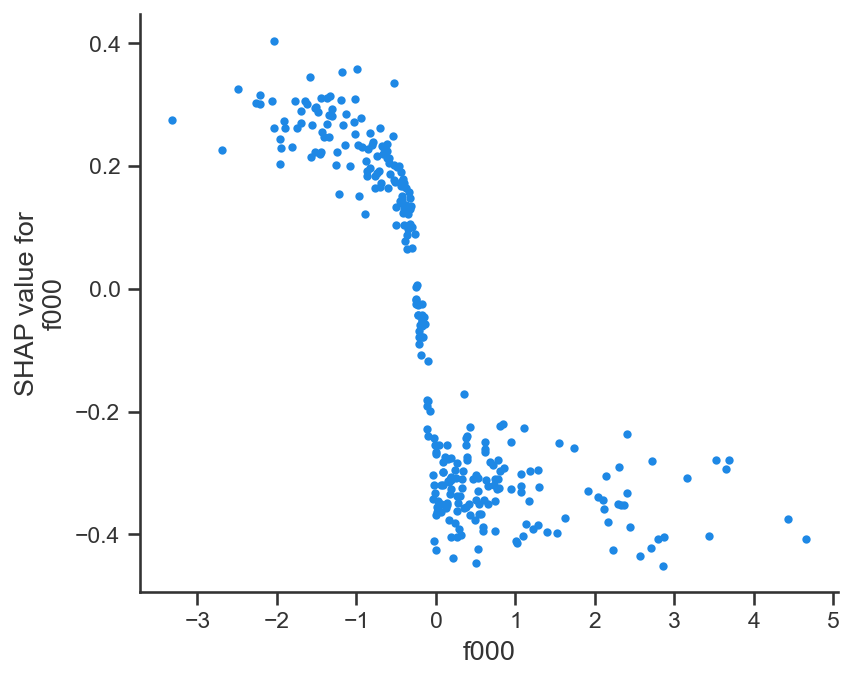

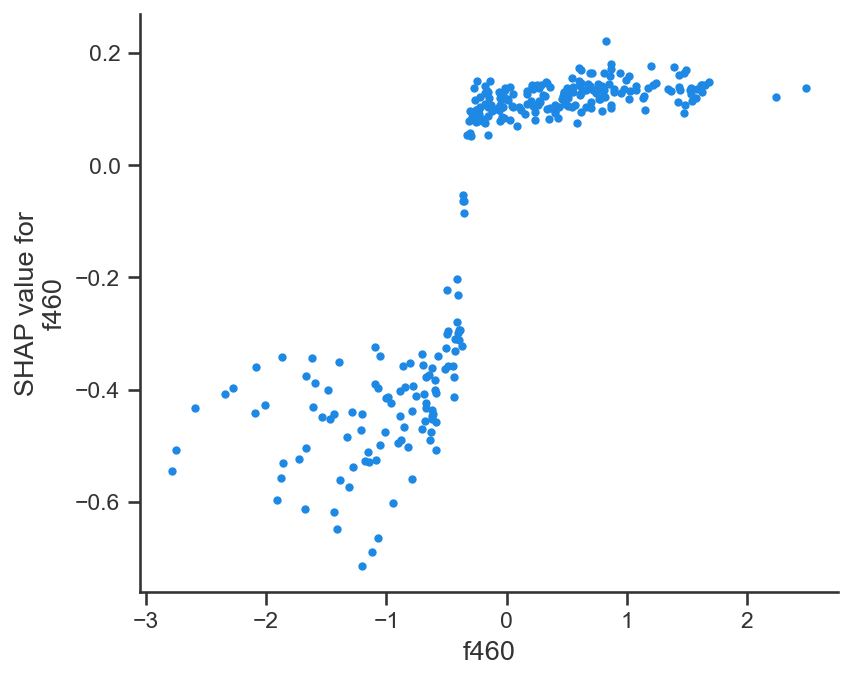

Top-15 overlap: ['f033', 'f059', 'f333', 'f460']
Jaccard (Top-15): 0.15

Top-10 (RF):
feature  mean|SHAP|
   f059    0.029454
   f033    0.007526
   f417    0.006053
   f549    0.005117
   f028    0.004943
   f562    0.004724
   f460    0.004695
   f290    0.004494
   f144    0.004478
   f205    0.004271

Top-10 (XGB):
feature  mean|SHAP|
   f059    1.084814
   f000    0.259728
   f460    0.227714
   f486    0.199378
   f333    0.196455
   f197    0.168108
   f163    0.166055
   f033    0.161547
   f038    0.154846
   f587    0.151018


In [14]:
# subset once
shap.initjs()
rng = np.random.default_rng(42)
Xte_df  = pd.DataFrame(Xte, columns=feat_cols)
idx_sub = rng.choice(len(Xte_df), size=min(300, len(Xte_df)), replace=False)
Xte_sub = Xte_df.iloc[idx_sub]

def shap_pos_class(vals, n_feats):
    """Return class-1 SHAP matrix aligned to Xte_sub (n_samples, n_features)."""
    out = vals[1] if isinstance(vals, list) else np.asarray(vals)
    # drop optional bias column if present
    if out.ndim == 3 and out.shape[-1] >= 2:
        out = out[:, :, 1]
    if out.shape[1] == n_feats + 1:
        out = out[:, :-1]
    if out.shape[1] != n_feats:          # final safeguard
        out = out[:, :n_feats]
    return out

# --- RandomForest ---
expl_rf  = shap.TreeExplainer(rf)
shap_rf  = shap_pos_class(expl_rf.shap_values(Xte_sub), Xte_sub.shape[1])
imp_rf   = pd.Series(np.abs(shap_rf).mean(axis=0), index=Xte_sub.columns)
top_rf   = imp_rf.nlargest(3).index.tolist()

shap.summary_plot(shap_rf, Xte_sub, feature_names=Xte_sub.columns, plot_type="bar", show=False)
savefig("04_shap_rf_summary_bar.png")
plt.show()

shap.summary_plot(shap_rf, Xte_sub, feature_names=Xte_sub.columns, show=False)
savefig("05_shap_rf_beeswarm.png")
plt.show()

for f in top_rf:
    shap.dependence_plot(f, shap_rf, Xte_sub, interaction_index=None, show=True)

# --- XGBoost ---
expl_xgb = shap.TreeExplainer(xgb)
shap_xgb = shap_pos_class(expl_xgb.shap_values(Xte_sub), Xte_sub.shape[1])
imp_xgb  = pd.Series(np.abs(shap_xgb).mean(axis=0), index=Xte_sub.columns)
top_xgb  = imp_xgb.nlargest(3).index.tolist()

shap.summary_plot(shap_xgb, Xte_sub, feature_names=Xte_sub.columns, plot_type="bar", show=False)
savefig("06_shap_xgb_summary_bar.png")
plt.show()

shap.summary_plot(shap_xgb, Xte_sub, feature_names=Xte_sub.columns, show=False)
savefig("07_shap_xgb_beeswarm.png")
plt.show()

for f in top_xgb:
    shap.dependence_plot(f, shap_xgb, Xte_sub, interaction_index=None, show=True)

# --- Optional: agreement / tables ---
def topk_table(shap_vals, names, k=10):
    mv  = np.abs(shap_vals).mean(axis=0)
    idx = np.argsort(mv)[::-1][:k]
    return pd.DataFrame({"feature": np.array(names)[idx], "mean|SHAP|": mv[idx]})

top15_rf = set(imp_rf.nlargest(15).index)
top15_xg = set(imp_xgb.nlargest(15).index)
jaccard  = len(top15_rf & top15_xg) / len(top15_rf | top15_xg)
print("Top-15 overlap:", sorted(top15_rf & top15_xg))
print(f"Jaccard (Top-15): {jaccard:.2f}")

print("\nTop-10 (RF):")
print(topk_table(shap_rf, Xte_sub.columns, 10).to_string(index=False))
print("\nTop-10 (XGB):")
print(topk_table(shap_xgb, Xte_sub.columns, 10).to_string(index=False))

#### 3.4 Cost-Sensitive Evaluation (validation-tuned thresholds --> reported on test)

In [15]:
# ---- helpers ----
def proba_sklearn(model, X):
    return model.predict_proba(X)[:, 1].astype("float64")

def proba_mlp(mlp, X):
    device = next(mlp.parameters()).device if list(mlp.parameters()) else torch.device("cpu")
    with torch.no_grad():
        Xt = torch.tensor(X, dtype=torch.float32, device=device)
        p  = torch.sigmoid(mlp(Xt)).cpu().numpy().ravel()
    return p.astype("float64")

def best_thr_by_cost(y, p, C_fp=1, C_fn=10):
    # choose threshold on *validation* that minimizes expected cost = C_fp*FP + C_fn*FN
    P, R, T = precision_recall_curve(y, p)   # T has length n-1
    Tfull = np.unique(np.r_[0.0, T, 1.0])    # include extremes
    costs, thrs = [], []
    for thr in Tfull:
        pred = (p >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
        costs.append(C_fp*fp + C_fn*fn); thrs.append(thr)
    j = int(np.argmin(costs))
    return float(thrs[j])

def eval_at(y, p, thr, C_fp=1, C_fn=10):
    pred = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    return {
        "thr": float(thr),
        "Cost": int(C_fp*fp + C_fn*fn),
        "PR_AUC": float(average_precision_score(y, p)),
        "ROC_AUC": float(roc_auc_score(y, p)),
        "BalancedAcc": float(balanced_accuracy_score(y, pred)),
        "Precision": float(tp/(tp+fp) if (tp+fp)>0 else 0.0),
        "Recall": float(tp/(tp+fn) if (tp+fn)>0 else 0.0),
        "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
    }

# ---- collect validation/test probabilities for all loaded models ----
cands = {}

try: cands["Logistic"] = (proba_sklearn(lr, Xva), proba_sklearn(lr, Xte))
except: pass
try: cands["RandomForest"] = (proba_sklearn(rf, Xva), proba_sklearn(rf, Xte))
except: pass
try: cands["XGBoost"] = (proba_sklearn(xgb, Xva), proba_sklearn(xgb, Xte))
except: pass
try: cands["FeatureSel (best pipe)"] = (proba_sklearn(best_sel_pipe, Xva), proba_sklearn(best_sel_pipe, Xte))
except: pass
try: cands["MLP"] = (proba_mlp(mlp_model, Xva), proba_mlp(mlp_model, Xte))
except: pass
# Stacking (rebuild inputs from base models)
try:
    lr_v, rf_v, mlp_v = proba_sklearn(lr, Xva), proba_sklearn(rf, Xva), proba_mlp(mlp_model, Xva)
    lr_t, rf_t, mlp_t = proba_sklearn(lr, Xte), proba_sklearn(rf, Xte), proba_mlp(mlp_model, Xte)
    Xva_stack = np.vstack([lr_v, rf_v, mlp_v]).T
    Xte_stack = np.vstack([lr_t, rf_t, mlp_t]).T
    cands["Stacking (meta)"] = (proba_sklearn(meta, Xva_stack), proba_sklearn(meta, Xte_stack))
except Exception:
    pass

print("Cost-sensitive eval — included models:", list(cands.keys()))

# ---- sweep FN:FP ratios, tune on val, report on test ----
ratios = [5, 10, 20]  # adjust if you want a denser sweep
rows = []
for name, (p_val, p_test) in cands.items():
    for r in ratios:
        thr = best_thr_by_cost(yva, p_val, C_fp=1, C_fn=r)
        res = eval_at(yte, p_test, thr, C_fp=1, C_fn=r)
        rows.append({"Model": name, "FN:FP": f"{r}:1", **res})

df_cost = (pd.DataFrame(rows)
           .sort_values(["FN:FP","Cost","Model"])
           .reset_index(drop=True))

display(df_cost[["Model","FN:FP","Cost","thr","Precision","Recall","BalancedAcc","PR_AUC","ROC_AUC","TP","FP","TN","FN"]]
        .round({"thr":4,"Precision":3,"Recall":3,"BalancedAcc":3,"PR_AUC":3,"ROC_AUC":3}))

# ---- (optional) per-ratio winner summary ----
winners = (df_cost.loc[df_cost.groupby("FN:FP")["Cost"].idxmin(), ["FN:FP","Model","Cost","thr","Precision","Recall"]]
           .reset_index(drop=True))
print("\nPer-ratio minimum-cost model:")
print(winners.to_string(index=False))

Cost-sensitive eval — included models: ['Logistic', 'RandomForest', 'XGBoost', 'FeatureSel (best pipe)', 'MLP', 'Stacking (meta)']


,Model,FN:FP,Cost,thr,Precision,Recall,BalancedAcc,PR_AUC,ROC_AUC,TP,FP,TN,FN
0,Logistic,10:1,170,1.0000,0.000,0.000,0.500,0.120,0.643,0,0,297,17
1,MLP,10:1,170,1.0000,0.000,0.000,0.500,0.074,0.585,0,0,297,17
2,RandomForest,10:1,170,1.0000,0.000,0.000,0.500,0.072,0.617,0,0,297,17
3,Stacking (meta),10:1,170,1.0000,0.000,0.000,0.500,0.079,0.604,0,0,297,17
4,XGBoost,10:1,170,1.0000,0.000,0.000,0.500,0.061,0.552,0,0,297,17
5,FeatureSel (best pipe),10:1,171,0.4638,0.083,0.059,0.511,0.083,0.525,1,11,286,16
6,MLP,20:1,244,0.1509,0.077,0.706,0.611,0.074,0.585,12,144,153,5
7,Stacking (meta),20:1,251,0.4844,0.074,0.706,0.599,0.079,0.604,12,151,146,5
8,XGBoost,20:1,263,0.0208,0.065,0.824,0.570,0.061,0.552,14,203,94,3
9,RandomForest,20:1,281,0.0675,0.073,0.471,0.565,0.072,0.617,8,101,196,9



Per-ratio minimum-cost model:
FN:FP    Model  Cost      thr  Precision   Recall
 10:1 Logistic   170 1.000000   0.000000 0.000000
 20:1      MLP   244 0.150909   0.076923 0.705882
  5:1 Logistic    85 1.000000   0.000000 0.000000


#### 3.5. Cost-Ratio Sweep (FN:FP = 1 --> 30)

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/08_cost_vs_fn_fp_ratio.png


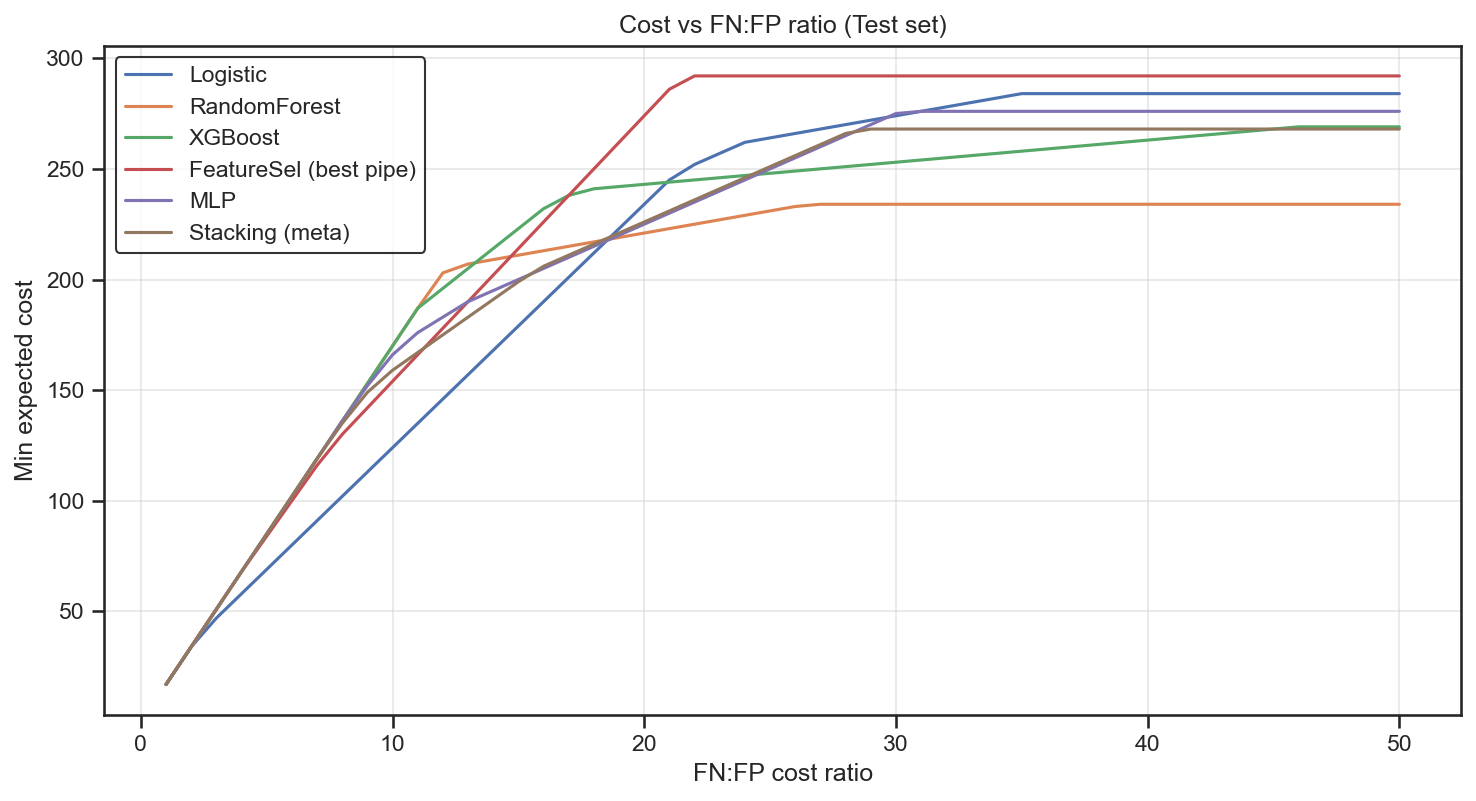

Per-ratio minimum-cost models:
 Ratio        Model  Cost     thr  Precision   Recall
     1     Logistic    17 1.00000   0.000000 0.000000
     2     Logistic    34 1.00000   0.000000 0.000000
     3     Logistic    47 0.01777   0.300000 0.352941
     4     Logistic    58 0.01777   0.300000 0.352941
     5     Logistic    69 0.01777   0.300000 0.352941
     6     Logistic    80 0.01777   0.300000 0.352941
     7     Logistic    91 0.01777   0.300000 0.352941
     8     Logistic   102 0.01777   0.300000 0.352941
     9     Logistic   113 0.01777   0.300000 0.352941
    10     Logistic   124 0.01777   0.300000 0.352941
    11     Logistic   135 0.01777   0.300000 0.352941
    12     Logistic   146 0.01777   0.300000 0.352941
    13     Logistic   157 0.01777   0.300000 0.352941
    14     Logistic   168 0.01777   0.300000 0.352941
    15     Logistic   179 0.01777   0.300000 0.352941
    16     Logistic   190 0.01777   0.300000 0.352941
    17     Logistic   201 0.01777   0.300000 0.3529

In [16]:
# ===== 3.5 — Cost-Ratio Sweep with stable crossovers =====
# Config
BASELINE  = "Logistic"   # change if you want a different reference
MAX_RATIO = 50          # supports 1:300
STEP      = 1
K_STABLE  = 3            # require K consecutive ratios cheaper than baseline

# Helpers
def best_cost_for_ratio(y_true, p, ratio):
    prec, rec, thr = precision_recall_curve(y_true, p)
    thr_grid = np.unique(np.r_[thr, 0.0, 1.0])
    best = None
    for t in thr_grid:
        pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        cost = fp*1 + fn*ratio
        if (best is None) or (cost < best["Cost"]):
            best = {
                "thr": float(t),
                "Cost": int(cost),
                "Precision": tp/(tp+fp) if (tp+fp) > 0 else 0.0,
                "Recall":    tp/(tp+fn) if (tp+fn) > 0 else 0.0,
                "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn)
            }
    return best

# Collect model->proba from your 'curves' dict (built earlier in 3.2)
models_cost = {name: proba for name, proba in curves.items()}

# Sweep
ratios = list(range(1, MAX_RATIO + 1, STEP))
rows = []
for name, proba in models_cost.items():
    for r in ratios:
        best = best_cost_for_ratio(yte, proba, r)
        best.update({"Model": name, "Ratio": r})
        rows.append(best)
df_cost = pd.DataFrame(rows)

# Plot cost curves
plt.figure(figsize=(10,5.5))
for name in df_cost["Model"].unique():
    sub = df_cost[df_cost["Model"] == name]
    plt.plot(sub["Ratio"], sub["Cost"], label=name)
plt.xlabel("FN:FP cost ratio")
plt.ylabel("Min expected cost")
plt.title("Cost vs FN:FP ratio (Test set)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
savefig("08_cost_vs_fn_fp_ratio.png")
plt.show()

# Winners per ratio
winners = (df_cost.loc[df_cost.groupby("Ratio")["Cost"].idxmin()]
           [["Ratio","Model","Cost","thr","Precision","Recall"]])
print("Per-ratio minimum-cost models:")
print(winners.to_string(index=False))

# Stable crossover finder vs baseline
def crossovers_vs_baseline(df_cost, baseline, ratios, k=K_STABLE):
    if baseline not in df_cost["Model"].unique():
        print(f"[warn] Baseline '{baseline}' not found among models.")
        return pd.DataFrame(columns=["Model","Crossover_at_ratio"])
    base = (df_cost[df_cost.Model == baseline]
            .set_index("Ratio")["Cost"]
            .reindex(ratios))

    out = []
    for name in df_cost["Model"].unique():
        if name == baseline:
            continue
        other = (df_cost[df_cost.Model == name]
                 .set_index("Ratio")["Cost"]
                 .reindex(ratios))
        diff = (other - base).to_numpy()  # negative => other cheaper

        # 1) Stable crossover: first index where k consecutive diffs < 0
        stable_idx = None
        if len(diff) >= k:
            run = np.convolve((diff < 0).astype(int), np.ones(k, dtype=int), mode="valid")
            hits = np.where(run == k)[0]
            if hits.size:
                stable_idx = hits[0]  # window start
        if stable_idx is not None:
            out.append({"Model": name, "Crossover_at_ratio": ratios[stable_idx]})
            continue

        # 2) Fallback: classic sign change (any crossing)
        sign = np.sign(diff)
        flip = np.where(sign[:-1] * sign[1:] < 0)[0]
        if flip.size:
            out.append({"Model": name, "Crossover_at_ratio": ratios[flip[0] + 1]})
            continue

        # 3) Dominance summaries
        if np.all(diff < 0):
            out.append({"Model": name, "Crossover_at_ratio": f"always cheaper (1→{MAX_RATIO})"})
        elif np.all(diff > 0):
            out.append({"Model": name, "Crossover_at_ratio": f"always costlier (1→{MAX_RATIO})"})
        else:
            out.append({"Model": name, "Crossover_at_ratio": "no clean crossover"})
    return pd.DataFrame(out)

def pretty_print_crossovers(df, baseline, max_ratio=MAX_RATIO):
    print(f"\nStable crossovers vs baseline: {baseline}")
    for _, row in df.iterrows():
        model = row["Model"]
        val   = row["Crossover_at_ratio"]
        if isinstance(val, (int, np.integer, float, np.floating)):
            r = int(round(val))
            print(f"Crossover {model}: FN:FP ≈ {r}:1")
        else:
            s = str(val)
            if "always cheaper" in s:
                print(f"Crossover {model}: always cheaper across 1–{max_ratio}:1")
            elif "always costlier" in s:
                print(f"Crossover {model}: always costlier across 1–{max_ratio}:1")
            else:
                print(f"Crossover {model}: {s}")

res = crossovers_vs_baseline(df_cost, BASELINE, ratios)
pretty_print_crossovers(res, BASELINE, MAX_RATIO)

#### 3.6 — Bootstrap Confidence Intervals (PR-AUC, ROC-AUC, BalancedAcc, Precision/Recall @ fixed thresholds)

In [17]:
# Uses validation to fix thresholds (F1-opt and Recall≥10%), then bootstraps the TEST set.
B = 1000                      # bootstrap replicates (reduce to 300 for speed)
RECALL_TARGET = 0.10
rng = np.random.default_rng(42)

# --- helper: fixed thresholds from validation ---
def thr_f1_from_val(y, p):
    prec, rec, thr = precision_recall_curve(y, p)
    # f1 defined for points with a threshold (skip the last PR point without thr)
    f1 = (2*prec[:-1]*rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    return float(thr[np.nanargmax(f1)]) if len(thr) else 0.5

def thr_recall_from_val(y, p, target=RECALL_TARGET):
    # smallest threshold that achieves >= target recall on validation
    prec, rec, thr = precision_recall_curve(y, p)
    mask = rec[:-1] >= target
    if mask.any():
        # choose the largest threshold that still keeps recall >= target (more precision)
        idx = np.where(mask)[0][-1]
        return float(thr[idx])
    # fallback: guarantee at least one positive by taking min threshold
    return float(np.min(p) - 1e-12)

# --- collect validation probabilities (to set thresholds) ---
def proba_of(model, X):
    try:
        return proba_sklearn(model, X)
    except Exception:
        return proba_mlp(model, X)

val_probs = {}
for name in curves.keys():
    if name == "Logistic":
        val_probs[name] = proba_of(lr, Xva)
    elif name == "RandomForest":
        val_probs[name] = proba_of(rf, Xva)
    elif name == "XGBoost":
         val_probs[name] = proba_of(xgb, Xva)
    elif name == "FeatureSel (best pipe)":
        val_probs[name] = proba_of(best_sel_pipe, Xva)
    elif name == "MLP":
         val_probs[name] = proba_mlp(mlp_model, Xva)
    elif name == "Stacking (meta)":
        # rebuild meta inputs on VAL the same way as test
        lr_p, rf_p, mlp_p = proba_of(lr, Xva), proba_of(rf, Xva), proba_mlp(mlp_model, Xva)
        Xva_stack = np.vstack([lr_p, rf_p, mlp_p]).T
        val_probs[name] = proba_of(meta, Xva_stack)

# thresholds per model (fixed from validation)
thr_f1 = {m: thr_f1_from_val(yva, pv) for m, pv in val_probs.items()}
thr_r10 = {m: thr_recall_from_val(yva, pv, RECALL_TARGET) for m, pv in val_probs.items()}

# --- metrics helpers on a bootstrapped sample ---
def safe_auc(func, y, p):
    # returns NaN if only one class present in the sample
    try:
        return float(func(y, p))
    except Exception:
        return np.nan

def eval_at_threshold(y, p, t):
    pred = (p >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    bal  = balanced_accuracy_score(y, pred)
    return prec, rec, bal

# --- bootstrap loop (vectorized sampling of indices) ---
n = len(yte)
idx_mat = rng.integers(0, n, size=(B, n))  # (B x n) indices with replacement

results = []  # one dataframe per model, then concat

for model_name, p_test in curves.items():
    p_test = np.asarray(p_test, dtype=float)
    # storage
    pr_auc = np.empty(B); roc_auc = np.empty(B)
    prec_f1 = np.empty(B); rec_f1 = np.empty(B); bal_f1 = np.empty(B)
    prec_r10 = np.empty(B); rec_r10 = np.empty(B); bal_r10 = np.empty(B)

    t1 = thr_f1.get(model_name, 0.5)
    t2 = thr_r10.get(model_name, 0.0)

    for b in range(B):
        idx = idx_mat[b]
        yb, pb = yte[idx], p_test[idx]
        pr_auc[b]  = safe_auc(average_precision_score, yb, pb)
        roc_auc[b] = safe_auc(roc_auc_score, yb, pb)

        pf, rf_, bf = eval_at_threshold(yb, pb, t1)
        pr10, rr10, br10 = eval_at_threshold(yb, pb, t2)

        prec_f1[b], rec_f1[b], bal_f1[b] = pf, rf_, bf
        prec_r10[b], rec_r10[b], bal_r10[b] = pr10, rr10, br10

    def ci_stats(a):
        lo, hi = np.nanpercentile(a, [2.5, 97.5])
        return np.nanmean(a), lo, hi

    rows = []
    for metric, arr in [
        ("PR_AUC", pr_auc),
        ("ROC_AUC", roc_auc),
        ("Precision@F1thr", prec_f1),
        ("Recall@F1thr",    rec_f1),
        ("BalancedAcc@F1thr", bal_f1),
        (f"Precision@Rec≥{int(RECALL_TARGET*100)}%thr", prec_r10),
        (f"Recall@Rec≥{int(RECALL_TARGET*100)}%thr",    rec_r10),
        (f"BalancedAcc@Rec≥{int(RECALL_TARGET*100)}%thr", bal_r10),
    ]:
        mean, lo, hi = ci_stats(arr)
        rows.append({"Model": model_name, "Metric": metric,
                     "Mean": mean, "CI_low": lo, "CI_high": hi})

    results.append(pd.DataFrame(rows))

df_boot = pd.concat(results, ignore_index=True)

# pretty table per model
def fmt_row(r):
    return f"{r['Mean']:.3f} [{r['CI_low']:.3f},{r['CI_high']:.3f}]"
pivot = (df_boot
         .assign(CI=lambda d: d.apply(fmt_row, axis=1))
         .pivot(index="Model", columns="Metric", values="CI")
         .reset_index())

print(f"Bootstrap 95% CIs (B={B}) — metrics on TEST; thresholds fixed from VAL:")
display(pivot)

Bootstrap 95% CIs (B=1000) — metrics on TEST; thresholds fixed from VAL:


Metric,Model,BalancedAcc@F1thr,BalancedAcc@Rec≥10%thr,PR_AUC,Precision@F1thr,Precision@Rec≥10%thr,ROC_AUC,Recall@F1thr,Recall@Rec≥10%thr
0,FeatureSel (best pipe),"0.537 [0.429,0.656]","0.545 [0.437,0.665]","0.102 [0.040,0.198]","0.071 [0.017,0.138]","0.077 [0.017,0.148]","0.528 [0.361,0.693]","0.299 [0.095,0.533]","0.299 [0.095,0.533]"
1,Logistic,"0.497 [0.491,0.500]","0.652 [0.539,0.770]","0.136 [0.053,0.254]","0.000 [0.000,0.000]","0.303 [0.095,0.533]","0.640 [0.474,0.791]","0.000 [0.000,0.000]","0.350 [0.125,0.583]"
2,MLP,"0.609 [0.492,0.717]","0.493 [0.450,0.556]","0.083 [0.041,0.140]","0.077 [0.038,0.121]","0.044 [0.000,0.143]","0.583 [0.430,0.721]","0.703 [0.467,0.923]","0.059 [0.000,0.188]"
3,RandomForest,"0.564 [0.441,0.686]","0.543 [0.434,0.660]","0.081 [0.041,0.135]","0.074 [0.028,0.126]","0.075 [0.016,0.143]","0.616 [0.509,0.727]","0.468 [0.235,0.706]","0.295 [0.077,0.533]"
4,Stacking (meta),"0.522 [0.455,0.614]","0.522 [0.455,0.614]","0.090 [0.044,0.158]","0.085 [0.000,0.217]","0.085 [0.000,0.217]","0.602 [0.455,0.739]","0.118 [0.000,0.300]","0.118 [0.000,0.300]"
5,XGBoost,"0.547 [0.421,0.673]","0.454 [0.384,0.547]","0.067 [0.036,0.104]","0.064 [0.027,0.103]","0.032 [0.000,0.081]","0.553 [0.429,0.681]","0.586 [0.333,0.833]","0.123 [0.000,0.308]"


Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/09_bootstrap_forest_PR_AUC.png


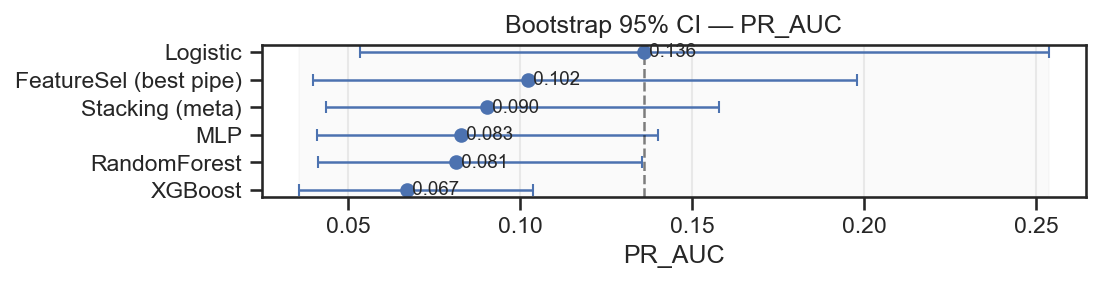

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/09_bootstrap_forest_ROC_AUC.png


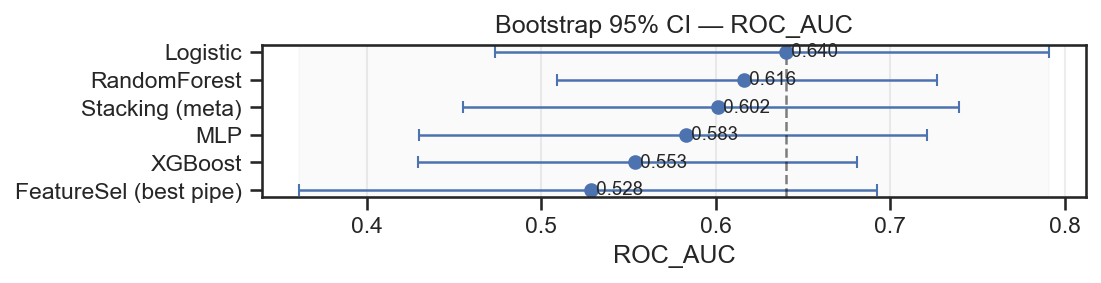

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/09_bootstrap_forest_Precision@F1thr.png


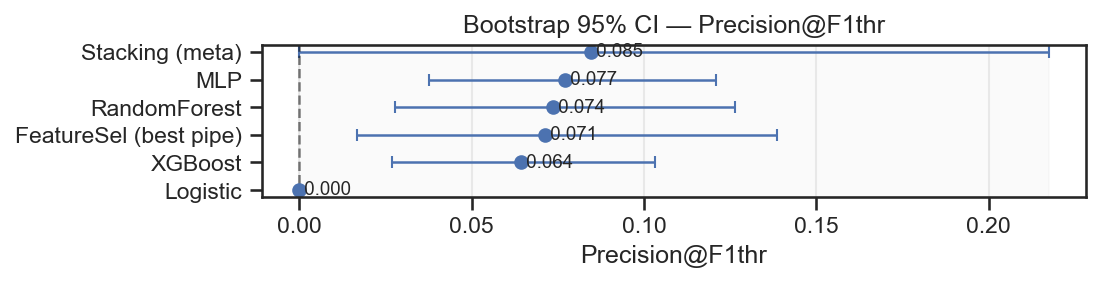

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/09_bootstrap_forest_Recall@F1thr.png


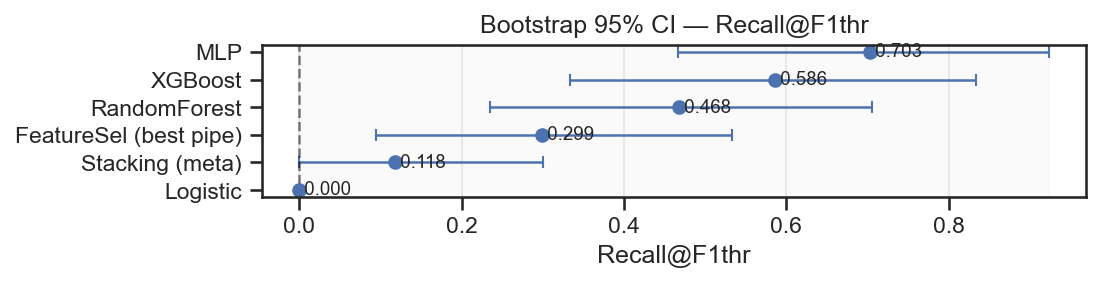

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/09_bootstrap_forest_BalancedAcc@F1thr.png


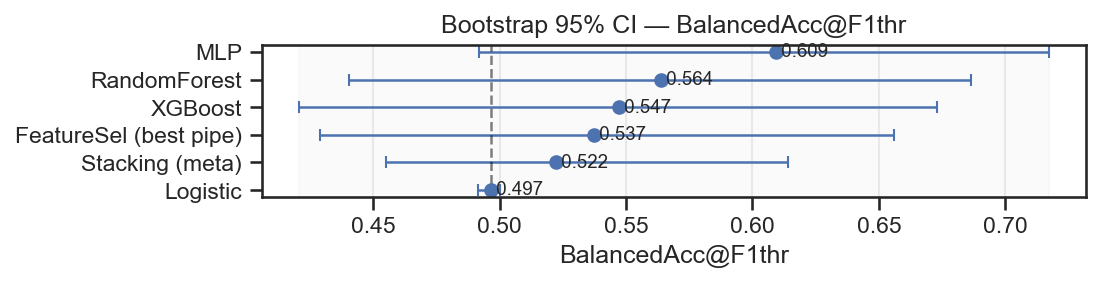

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/09_bootstrap_forest_Precision@Recge10%thr.png


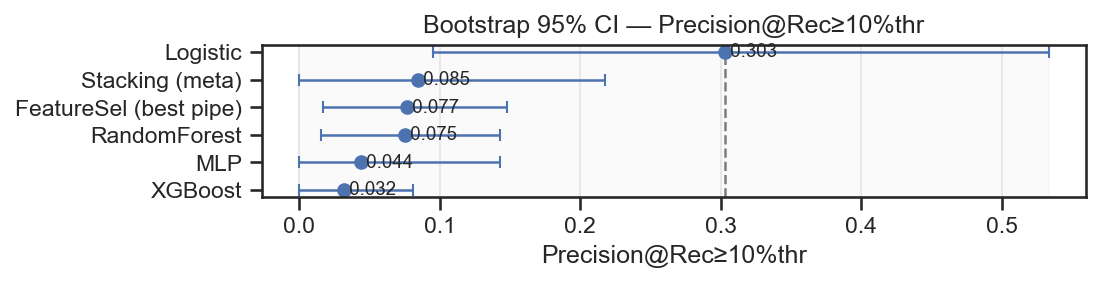

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/09_bootstrap_forest_Recall@Recge10%thr.png


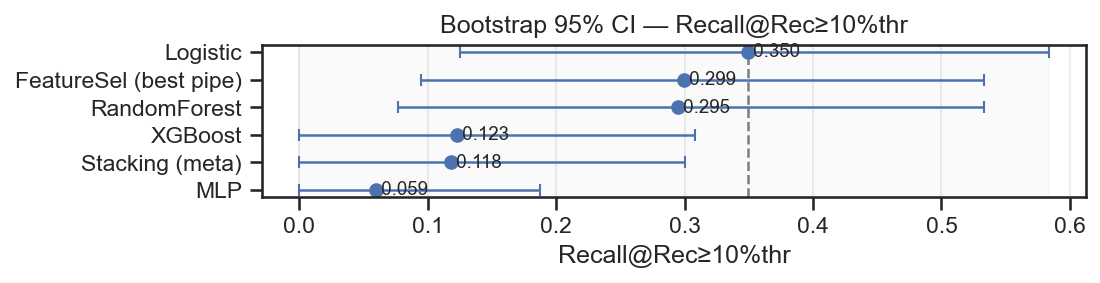

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/interpretability/09_bootstrap_forest_BalancedAcc@Recge10%thr.png


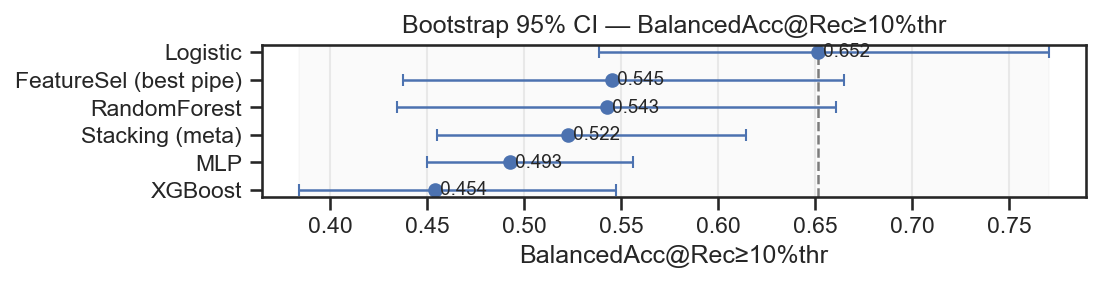

In [18]:
# Forest plots for bootstrap CIs
# expects df_boot with columns: Model, Metric, Mean, CI_low, CI_high
# (from the bootstrap block you just ran)
def plot_forest(df_boot, baseline=None, alpha_ci=0.2):
    metrics = df_boot["Metric"].unique()
    for metric in metrics:
        sub = (df_boot[df_boot["Metric"] == metric]
               .sort_values("Mean").reset_index(drop=True))
        y = np.arange(len(sub))
        err_low  = sub["Mean"] - sub["CI_low"]
        err_high = sub["CI_high"] - sub["Mean"]

        h = 0.55 + 0.25*len(sub)  # dynamic height
        fig, ax = plt.subplots(figsize=(7.5, h))

        ax.errorbar(sub["Mean"], y,
                    xerr=[err_low, err_high],
                    fmt="o", capsize=3, elinewidth=1.2, lw=0)
        
        for i, m in enumerate(sub["Mean"]):
            ax.text(m, i, f" {m:.3f}", va="center", ha="left", fontsize=9)

        # Optional: shade CI band extremes for context
        ax.axvspan(sub["CI_low"].min(), sub["CI_high"].max(), color="gray", alpha=alpha_ci*0.2)

        # Optional: baseline vertical line
        if baseline is not None and baseline in set(sub["Model"]):
            try:
                base_mean = float(sub.loc[sub["Model"] == baseline, "Mean"].iloc[0])
                ax.axvline(base_mean, ls="--", lw=1.2, alpha=0.5, color="black")
            except Exception:
                pass

        ax.set_yticks(y)
        ax.set_yticklabels(sub["Model"])
        ax.set_xlabel(metric)
        ax.set_title(f"Bootstrap 95% CI — {metric}")
        ax.grid(True, axis="x", alpha=0.35)

        # Save per metric
        savefig(f"09_bootstrap_forest_{metric.replace(' ','_').replace('≥','ge').replace(':','_')}.png")

        # Nice x-limits with a little padding
        x_min = (sub["CI_low"].min())
        x_max = (sub["CI_high"].max())
        pad = 0.05 * (x_max - x_min if x_max > x_min else 1.0)
        ax.set_xlim(x_min - pad, x_max + pad)

        plt.tight_layout()
        plt.show()

# Call it (uses BASELINE from 3.5 if present)
try:
    plot_forest(df_boot, baseline=BASELINE)
except NameError:
    plot_forest(df_boot, baseline=None)

#### 3.7. Save all the necessary information for further reserach.

In [19]:
# Save Artifacts
ART = Path(ROOT/"artifacts"); ART.mkdir(parents=True, exist_ok=True)

# 1) data & features
joblib.dump({"feat_cols": feat_cols,
             "Xva": Xva, "yva": yva,
             "Xte": Xte, "yte": yte}, ART/"data_splits.joblib")

# 2) test probs (curves) and val probs
joblib.dump(curves, ART/"test_probs.joblib")        # dict: model -> p_test
try:
    joblib.dump(val_probs, ART/"val_probs.joblib")  # dict: model -> p_val
except NameError:
    # rebuild minimal val_probs from loaded models
    def _prob(model, X):
        try: return model.predict_proba(X)[:,1]
        except: return proba_mlp(mlp_model, X)
    _val = {}
    if "Logistic" in curves:    _val["Logistic"] = _prob(lr, Xva)
    if "RandomForest" in curves:_val["RandomForest"] = _prob(rf, Xva)
    if "XGBoost" in curves:     _val["XGBoost"] = _prob(xgb, Xva)
    if "FeatureSel (best pipe)" in curves: _val["FeatureSel (best pipe)"] = _prob(best_sel_pipe, Xva)
    if "MLP" in curves:         _val["MLP"] = proba_mlp(mlp_model, Xva)
    if "Stacking (meta)" in curves:
        lr_v, rf_v, mlp_v = _prob(lr,Xva), _prob(rf,Xva), proba_mlp(mlp_model,Xva)
        Xva_stack = np.vstack([lr_v, rf_v, mlp_v]).T
        _val["Stacking (meta)"] = meta.predict_proba(Xva_stack)[:,1]
    joblib.dump(_val, ART/"val_probs.joblib")

# 3) thresholds from validation (F1-opt, Recall≥10%)
def _align_pr(y, p):
    from sklearn.metrics import precision_recall_curve
    P,R,T = precision_recall_curve(y, p); return P[:-1], R[:-1], T
def _thr_f1(y,p, beta=1.0):
    P,R,T = _align_pr(y,p); F=(1+beta**2)*(P*R)/(beta**2*P+R+1e-12)
    return float(T[int(np.nanargmax(F))]) if len(T) else 0.5
def _thr_r10(y,p, floor=0.10):
    P,R,T = _align_pr(y,p); ok=np.where(R>=floor)[0]
    return float(T[ok[np.argmax(P[ok])]]) if ok.size else (_thr_f1(y,p))

_val = joblib.load(ART/"val_probs.joblib")
thr_f1  = {m: _thr_f1(yva, pv) for m, pv in _val.items()}
thr_r10 = {m: _thr_r10(yva, pv, 0.10) for m, pv in _val.items()}
joblib.dump({"thr_f1": thr_f1, "thr_r10": thr_r10}, ART/"thresholds.joblib")

# 4) SHAP top-k features (if computed)
try:
    top_rf  = list(pd.Series(np.abs(shap_rf).mean(axis=0), index=Xte_sub.columns).nlargest(10).index)
    top_xgb = list(pd.Series(np.abs(shap_xgb).mean(axis=0), index=Xte_sub.columns).nlargest(10).index)
    joblib.dump({"RF_top10": top_rf, "XGB_top10": top_xgb}, ART/"shap_topk.joblib")
except Exception:
    pass

# 5) Optional: cost sweep & bootstrap tables if present
try: joblib.dump(df_cost, ART/"cost_sweep_df.joblib")
except Exception: pass
try: joblib.dump(df_boot, ART/"bootstrap_df.joblib")
except Exception: pass

print("Saved artifacts to:", ART.resolve())

Saved artifacts to: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/artifacts
